# Определение возраста покупателей

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

План выполнения проекта
1) Исследовательский анализ набора фотографий.

2) Подготовка данных к обучению.

3) Обучение нейронной сеть и рассчет её качества.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


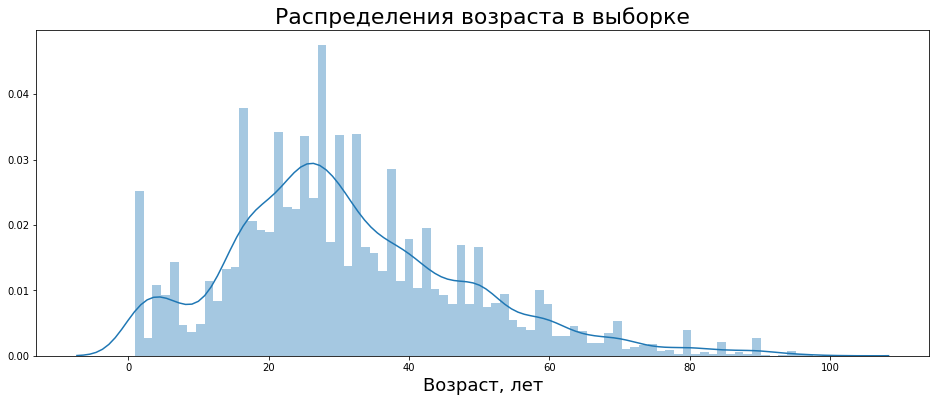

In [6]:
plt.figure(figsize=(16,6))
sns.distplot(labels["real_age"], kde = True, bins = 80)
plt.title('Распределения возраста в выборке',fontsize=22)
plt.xlabel('Возраст, лет',fontsize=18)
plt.show()

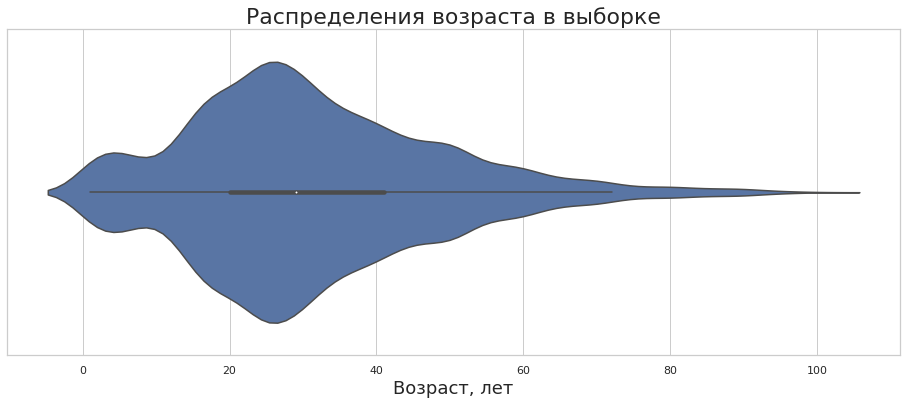

In [7]:
plt.figure(figsize=(16,6))
sns.set(style = "whitegrid")
sns.violinplot(x = labels["real_age"])
plt.title('Распределения возраста в выборке',fontsize=22)
plt.xlabel('Возраст, лет',fontsize=18)
plt.show()

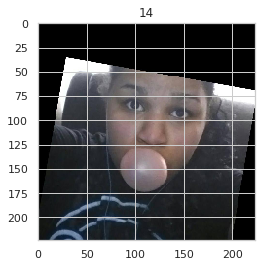

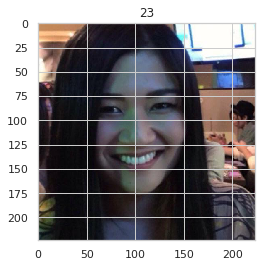

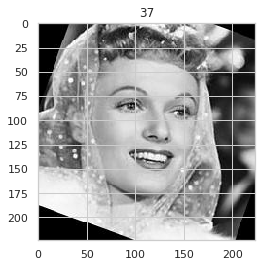

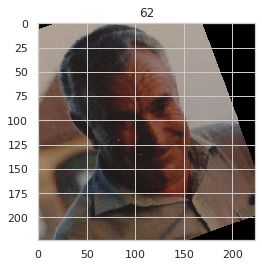

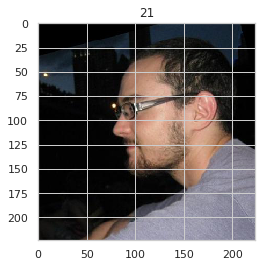

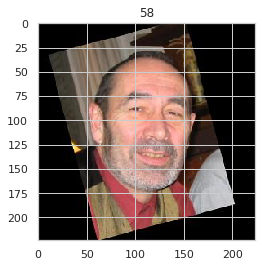

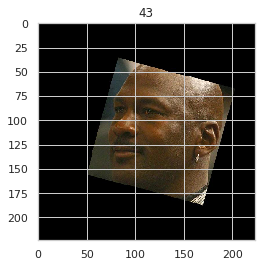

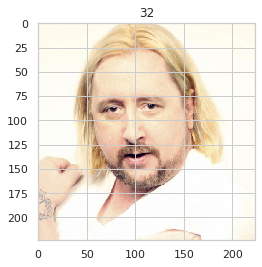

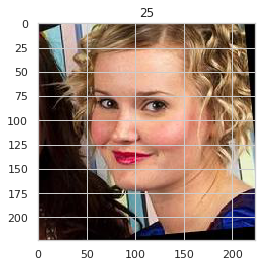

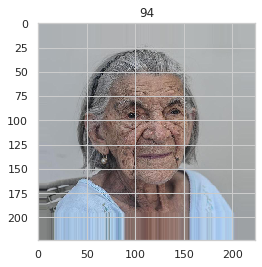

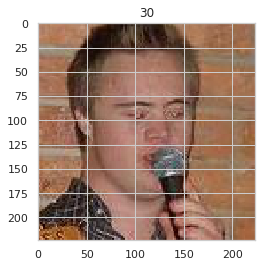

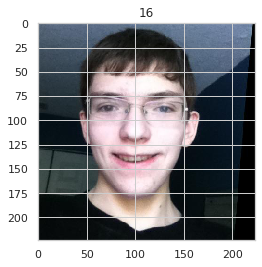

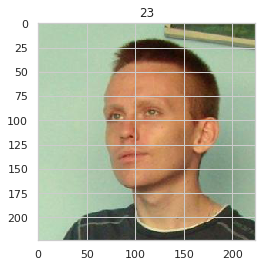

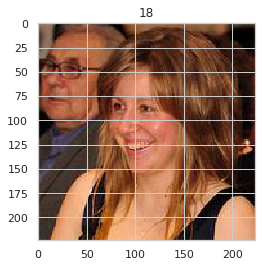

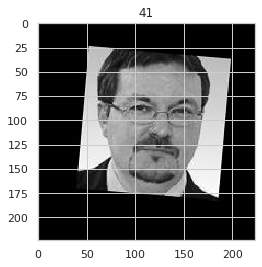

In [8]:
features, target = next(train_gen_flow)
for age, photo in zip(target[10:25], features[10:25]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

**Вывод по результатам анализа**

Предоставлена выборка из 7591 фотографий, минимальный возраст  1 год, максимальный - 100 лет.

В целом распределение близко к нормальному, есть выбросы (около 2-3 лет) и хвост справа (после 60 лет) 

Наибольшее количество фоторграфий людей между 20 и 41 годами.

Есть фотографии лиц в профиль, в очках, с наушниками, в головных уборах, лица частично прикрыты рукой, пузырем жевательной резинки или микрофоном. Есть фото явно из фильмов.

На мой взгляд фотографии немного обработаны, так как изображение сфокусированно по центру.

Однако возможно у модели будут затруднения в обучении с фотографиями в профиль и плохого качества (зернистые)

## Обучение модели

Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Epoch 1/10

178/178 - 155s - loss: 186.8747 - mae: 10.1913 - val_loss: 285.4820 - val_mae: 13.3365

Epoch 2/10

178/178 - 37s - loss: 103.0666 - mae: 7.6895 - val_loss: 486.2549 - val_mae: 16.8592

Epoch 3/10

178/178 - 36s - loss: 63.2858 - mae: 6.0775 - val_loss: 308.4105 - val_mae: 13.0176

Epoch 4/10

178/178 - 36s - loss: 41.1410 - mae: 4.9114 - val_loss: 206.3775 - val_mae: 10.5428

Epoch 5/10

178/178 - 36s - loss: 28.6848 - mae: 4.1223 - val_loss: 160.5349 - val_mae: 10.1624

Epoch 6/10

178/178 - 36s - loss: 22.2884 - mae: 3.6331 - val_loss: 121.4312 - val_mae: 8.6554

Epoch 7/10

178/178 - 36s - loss: 16.1350 - mae: 3.0895 - val_loss: 74.2678 - val_mae: 6.5419

Epoch 8/10

178/178 - 36s - loss: 12.6142 - mae: 2.7261 - val_loss: 78.0475 - val_mae: 6.7746

Epoch 9/10

178/178 - 37s - loss: 10.6125 - mae: 2.4851 - val_loss: 77.0406 - val_mae: 6.5056

Epoch 10/10

178/178 - 36s - loss: 10.5209 - mae: 2.4619 - val_loss: 77.0282 - val_mae: 6.5149

60/60 - 9s - loss: 77.0282 - mae: 6.5149

**Test MAE: 6.5149**

## Анализ обученной модели

Была обучена модель на архитектуре ResNet50 на 10 эпохах.

Для тренировочной выборки была применена аугментация.

На тестовой выборке удалось достичь показателя **MAE 6.51**, что в целом неплохо, учитывая наличие выбросов в данных в промежутке 2-4 года, 18 и 30 лет, а также хвост после 60 лет.

В целом модель неплохо предсказывает возраст, однако этот показатель MAE и качество модели можно улучшить поработав с выбросами и фото (сделать аугментацию больше)